In [63]:
import numpy as np
from sklearn import metrics
import os
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import kurtosis, skew
import statsmodels


In [64]:
def compute_auc(array_1, array_2):
    xs = np.concatenate([array_1, array_2],axis=1)
    y = np.concatenate([array_1.shape[1]*[2], array_2.shape[1]*[1]])
    
    for i, x in enumerate(xs):
        fpr, tpr, thresholds = metrics.roc_curve(y, x, pos_label=2)
        #print(i, metrics.auc(fpr, tpr))
        m = metrics.roc_auc_score(y, x)
        print(round(max(m, 1-m), 2))

def compute_eta_squared(H, n_of_grp,n_of_observ):
    return (H - n_of_grp + 1)/(n_of_observ - n_of_grp)

def delete_multiple_element(list_object, indices):
    indices = sorted(indices, reverse=True)
    for idx in indices:
        if idx < len(list_object):
            list_object.pop(idx)
            
    return list_object

def kruskal(f, task, c, p, c_name, p_name):
    for i, title in enumerate(task):
        nome = title
        f.write(('\n'+ f'kruskal results for {title} {c_name} {p_name} {stats.kruskal(c[i], p[i]).pvalue} \n\n'))
        

def holm_correction(kruskal):
    line_to_remove=[]
    values=[]
    corrected =[]
    final = []
    for l in kruskal:
        if "nan" in l:
            line_to_remove.append(kruskal.index(l))
    
    new_krusk = delete_multiple_element(kruskal, line_to_remove)
            
    for line in new_krusk:
        ok = line.split('vs.')[1]
        num = ok.split(" ")[2]
        values.append(float(num))
    result = statsmodels.stats.multitest.fdrcorrection(values, alpha=0.05, method='indep', is_sorted=False)
    num = np.where(result[0] == True)
    list_index = ((num)[0]).tolist()

    for i in list_index:
        corrected.append(result[1][i])
    for i in list_index:
        final.append(kruskal[i])
    
    return final, corrected
    

def kruskal(f, task, c, p, c_name, p_name):
    for i, title in enumerate(task):
        nome = title
        f.write(('\n'+ f'kruskal results for {title} {c_name} {p_name} {stats.kruskal(c[i], p[i]).pvalue} \n\n'))
        
        
def read_stats_test(file):
    
    with open(file, 'r') as f:
        lista = []
        testo = f.readlines()
        testo = [line.strip("\n") for line in testo]

        for line in testo:
            if line=="":
                pass
            else:
                lista.append(line)
                
    return lista      

def compute_best_scores(lista):    

    values = []
    critical = []
    final = [] 
    
    for l in lista:
        ok = l.split('vs.')[1]
        num = ok.split(" ")[2]
        values.append(num)

    for value in values:
        if float(value) < 0.05:
            critical.append(value)

    for li in lista:
        for cri in critical:
            if cri in li:
                final.append(li)

    return final


word_analysis = []
path = os.listdir("/export/b15/afavaro/Frontiers/Neurovoz_data/Whole_Align/")
print(len(path))
for elem in path:
        word_analysis.append(os.path.join('/export/b15/afavaro/Frontiers/Neurovoz_data/Whole_Align/', elem))


list_of_dataframes = []
for element in word_analysis:
    participant = pd.read_csv(element)
    elem = os.path.basename(element)
    whole = elem.split("-16k")[0]
    name = elem.split("_", -1)[-1].split("-")[0]
    task = elem.split("_")[1]
    label = elem.split("_")[0]
   
    tot= participant.time_stamp.tolist()
    tot = (list(set(tot)))
    unique = participant['time_stamp'].unique()
    stdx = unique.std()
    kurtx = kurtosis(unique)
    skewx =  skew(unique)
    d = {'tot': whole, 'name': name, 'label': label, 'task': task,'rhythm_std': stdx,'rhythm_skew': skewx, 'rhythm_kurt': kurtx } # 'Rhythm_kurt': kurtosis, 
    df = pd.DataFrame(d, index =[0])
    list_of_dataframes.append(df)

data = pd.concat(list_of_dataframes, sort=False)
data.dropna()


data = data.sort_values( by="tot", ascending=False)
cog = pd.read_csv("/export/b15/afavaro/Frontiers/submission/Statistical_Analysis/NEUROVOZ/ling_data_with_events.csv")
cog = cog.sort_values( by="idx", ascending=False)
inf = cog['informational_verb'].tolist()
data['inform_verb'] = inf

# Group by task

task_grouped_ = data.groupby("task")
concatenateread = task_grouped_.get_group("concatenateread")
ESPONTANEA = task_grouped_.get_group("ESPONTANEA")

## ESPONTANEA (Spontaneous Speech)


ESPONTANEA = ESPONTANEA.drop(columns=['rhythm_skew', 'rhythm_kurt'])
task = ESPONTANEA.columns[4:].values.tolist()
grouped = ESPONTANEA.groupby("label") #here we extract the values by category
control = grouped.get_group("HC") 
parkinson_ = grouped.get_group("PD")
parkinson_all_feat = np.array([parkinson_[feat] for feat in np.array(ESPONTANEA.columns[4:])])
control_all_feat = np.array([control[feat] for feat in np.array(ESPONTANEA.columns[4:])])

with open('/export/b15/afavaro/Frontiers/submission/SPANISH/COGNITIVE/RESULTS/rhythm.txt', 'w') as f:
 
    kruskal(f, task, control_all_feat, parkinson_all_feat, "controls vs.", "parkinson")
    
kruskal_1 = read_stats_test('/export/b15/afavaro/Frontiers/submission/SPANISH/COGNITIVE/RESULTS/rhythm.txt')
holm_correction(kruskal_1)

for i, title in enumerate(task):  
    
    nome = title
    controls = []
    parkinson=[]
    data = np.concatenate([control_all_feat[i], parkinson_all_feat[i]])
    data = data.tolist()
    [controls.append('CN') for value in range(len(control_all_feat[i]))]
    [parkinson.append('PD') for value in range(len(parkinson_all_feat[i]))]
    lista = controls+parkinson
    dict = {nome: data, 'Group': lista} 
    df = pd.DataFrame(dict)
    sns.set(font_scale=2)
    sns.catplot(x=nome, y="Group", kind="boxen", data=df, k_depth='full', palette="Blues",\
               height=4.2, aspect=1.4, showfliers = False)


## Text dependent utterances (TDUs)

task = concatenateread.columns[4:-3].values.tolist()
grouped = concatenateread.groupby("label") #here we extract the values by category
control = grouped.get_group("HC") 
parkinson_ = grouped.get_group("PD")
parkinson_all_feat = np.array([parkinson_[feat] for feat in np.array(concatenateread.columns[4:-3])])
control_all_feat = np.array([control[feat] for feat in np.array(concatenateread.columns[4:-3])])

with open('/export/b15/afavaro/Frontiers/submission/SPANISH/COGNITIVE/RESULTS/rhythm_conc.txt', 'w') as f:
 
    kruskal(f, task, control_all_feat, parkinson_all_feat, "controls vs.", "parkinson")
    
kruskal_1 = read_stats_test('/export/b15/afavaro/Frontiers/submission/SPANISH/COGNITIVE/RESULTS/rhythm_conc.txt')
holm_correction(kruskal_1)

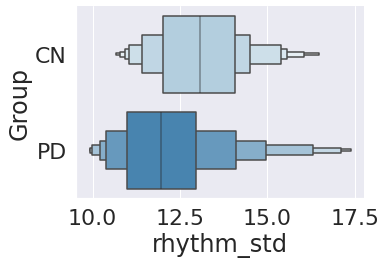

In [77]:
for i, title in enumerate(task):  
    
    nome = title
   
    controls = []
    parkinson=[]
    alz = []
    others= []
    
    data = np.concatenate([control_all_feat[i], parkinson_all_feat[i]])
    data = data.tolist()
    [controls.append('CN') for value in range(len(control_all_feat[i]))]
    [parkinson.append('PD') for value in range(len(parkinson_all_feat[i]))]
    lista = controls+parkinson
    dict = {nome: data, 'Group': lista} 
    df = pd.DataFrame(dict)

    sns.set(font_scale=2)
    sns.catplot(x=nome, y="Group", kind="boxen", data=df, k_depth='full', palette="Blues",\
               height=4.2, aspect=1.4, showfliers = False)
    
